In [12]:
from lib.utils import *
from lib.models import *
from lib.ekyn import *
from lib.env import *
from lib.datasets import *
class Gandalf(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = Frodo(n_features=5000,device=DEVICE).to(DEVICE)
        self.lstm = nn.LSTM(16,32,bidirectional=True)
        self.fc1 = nn.Linear(64,3)
    def forward(self,x_2d,classification=True):
        x_2d = x_2d.view(-1,9,1,5000)
        x = torch.Tensor().to(DEVICE)
        for t in range(x_2d.size(1)):
            xi = self.encoder(x_2d[:,t,:,:],classification=False)
            x = torch.cat([x,xi.unsqueeze(0)],dim=0)
        out,_ = self.lstm(x)
        if(classification):
            x = self.fc1(out[-1])
        else:
            x = out[-1]
        return x
model = Gandalf()

In [27]:
FOLD = 2
folds = get_leave_one_out_cv_ids_for_ekyn()
_,test_ids = folds[FOLD]
X,y = load_eeg_label_pairs(ids=test_ids)
testloader = DataLoader(Windowset(X,y),batch_size=32,shuffle=False)
criterion = torch.nn.CrossEntropyLoss()
model = Gandalf()
model.load_state_dict(torch.load(f=f'../models/gandalfs/gandalf_{FOLD}/best_model.pt',map_location='cpu'))
model.to(DEVICE)
loss,report,y_true,y_pred,y_logits = evaluate(testloader,model,criterion,DEVICE)

100%|██████████| 540/540 [00:20<00:00, 26.51it/s]


In [29]:
report

{'precision': 0.9323331343673208,
 'recall': 0.9219567062129949,
 'f1': 0.9269952893258777}

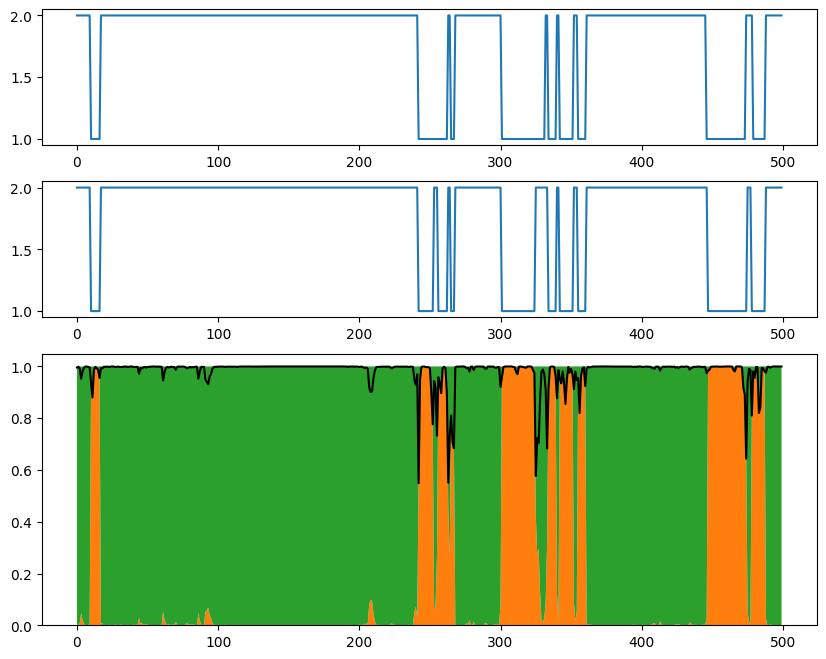

In [30]:
confidences = []
idx = y_logits.argmax(axis=1)
for logit,idx in zip(y_logits,idx):
    confidences.append(logit[idx].item())
fig,axes = plt.subplots(ncols=1,nrows=3,figsize=(10,8),dpi=100,gridspec_kw={'height_ratios': [1,1,2]})
upper = 1000
axes[2].stackplot(torch.arange(len(y_logits[500:upper])),y_logits[500:upper].T)
axes[2].plot(confidences[500:upper],'black')
axes[0].plot(y_true[500:upper])
axes[1].plot(y_pred[500:upper])